In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
from scipy import stats
import matplotlib
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Supplemental Figure 1/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
kang = sc.read("../data/train_pbmc.h5ad")
kang

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [4]:
hpoly = sc.read("../data/train_hpoly.h5ad")
hpoly

AnnData object with n_obs × n_vars = 5059 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [5]:
salmonella = sc.read("../data/train_salmonella.h5ad")
salmonella

AnnData object with n_obs × n_vars = 4259 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [6]:
def plot_binary_classifiers(adata, data_name, cell_type, conditions, cell_type_key):
    network = scgen.VAEArith(x_dimension=adata.shape[1], model_path=f"../models/scGen/{data_name}/{cell_type}/scgen")
    network.restore_model()
    unperturbed_data = adata[((adata.obs[cell_type_key] == cell_type) & (adata.obs["condition"] == conditions["ctrl"]))]
    net_train_data = adata[~((adata.obs[cell_type_key] == cell_type) & (adata.obs["condition"] == conditions["stim"]))]
    pred, delta = network.predict(adata=net_train_data, 
                                  adata_to_predict=unperturbed_data, 
                                  conditions=conditions,
                                  cell_type_key=cell_type_key,
                                  condition_key="condition")
    scgen.plotting.binary_classifier(network, adata, delta, condition_key="condition",
                                     conditions=conditions,
                                     fontsize=18,
                                     path_to_save=os.path.join(path_to_save, f"SupplFig1b_{data_name}_{cell_type}.pdf"))

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen


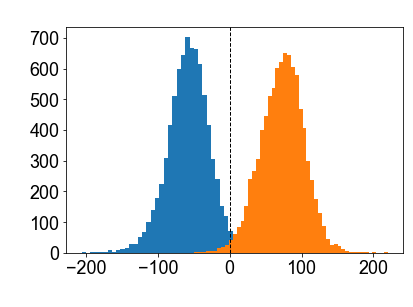

In [7]:
conditions = {"ctrl": "control", "stim": "stimulated"}
plot_binary_classifiers(kang, "pbmc", "CD4T", conditions, "cell_type")

INFO:tensorflow:Restoring parameters from ../models/scGen/hpoly/TA.Early/scgen


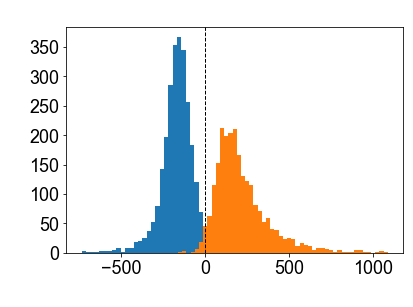

In [8]:
conditions = {"ctrl": "Control", "stim": "Hpoly.Day10"}
plot_binary_classifiers(hpoly, "hpoly", "TA.Early", conditions, "cell_label")

INFO:tensorflow:Restoring parameters from ../models/scGen/salmonella/Endocrine/scgen


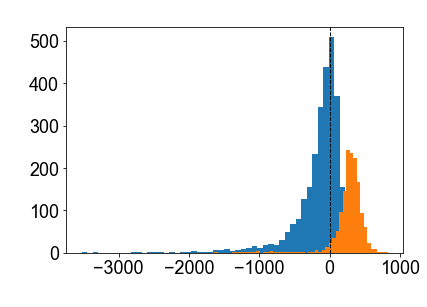

In [9]:
conditions = {"ctrl": "Control", "stim": "Salmonella"}
plot_binary_classifiers(salmonella, "salmonella", "Endocrine", conditions, "cell_label")

In [10]:
train_data = sc.read("../data/train_pbmc.h5ad")
train_data_real = train_data[~((train_data.obs["condition"] == "stimulated") & (train_data.obs["cell_type"] == "CD4T"))]

In [11]:
train_data.obs["cell_type"].cat.reorder_categories([ 'B', 'CD4T', 'CD8T', 'CD14+Mono','Dendritic', 'FCGR3A+Mono',"NK" ],\
                                       inplace=True, ordered=True)
train_data.rename_categories("cell_type",['B', 'CD4-T', 'CD8-T', 'CD14-Mono', 'DC', 'F-Mono', 'NK'],)

In [12]:
network = scgen.VAEArith(x_dimension=train_data.shape[1], z_dimension=100, model_path="../models/scGen/pbmc/CD4T/scgen")
network.restore_model()
all_data = network.to_latent(train_data.X.A)
adata_all = sc.AnnData(all_data)
adata_all.obs["condition"] = train_data.obs["condition"].tolist()
adata_all.obs["cell_type"] = train_data.obs["cell_type"].tolist()
adata_all

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen


AnnData object with n_obs × n_vars = 16893 × 100 
    obs: 'condition', 'cell_type'

In [13]:
train_real_cd = train_data_real[train_data_real.obs["condition"] == "control",:]
train_real_cd = scgen.util.balancer(train_real_cd)
train_real_stim = train_data_real[train_data_real.obs["condition"] == "stimulated",:]
train_real_stim = scgen.util.balancer(train_real_stim)
target = scgen.util.extractor(train_data_real, "CD4-T", conditions={"stim": "stimulated", "ctrl": "control"})

In [14]:
latent_stim = network.to_latent(train_real_stim.X)
latent_cd = network.to_latent(train_real_cd.X)

In [15]:
eq = min(len(latent_cd),len(latent_stim))
cd_ind = np.random.choice(range(len(latent_cd)),size=eq,replace=False)
HFD_ind = np.random.choice(range(len(latent_stim)),size=eq,replace=False)

In [16]:
delta_average = latent_stim[HFD_ind,:].mean(0) - latent_cd[cd_ind,:].mean(0)

In [17]:
latent_stim = sc.AnnData(latent_stim)
latent_stim.obs["condition"] = train_real_stim.obs["condition"]
latent_stim.obs["cell_type"] = train_real_stim.obs["cell_type"]
latent_cd = sc.AnnData(latent_cd)
latent_cd.obs["condition"] = train_real_cd.obs["condition"]
latent_cd.obs["cell_type"] = train_real_cd.obs["cell_type"]

In [18]:
cell_types = np.unique(adata_all.obs["cell_type"])

In [19]:
celladata = adata_all[adata_all.obs["cell_type"] == "CD4T"]
stim_all = adata_all[adata_all.obs["condition"] == "stimulated"]
ctrl_all = adata_all[adata_all.obs["condition"] == "control"]

In [20]:
delta = np.zeros((7,7,100))
labels = []
for i,j in enumerate(cell_types) :
    for m,n in enumerate(cell_types):
        stim = stim_all[(stim_all.obs["cell_type"] == j)].X
        cd = ctrl_all[(ctrl_all.obs["cell_type"] == n)].X
        if j == n:
            labels.append("cross_stim")
        else:
            labels.append("cross_celltype")
        eq = min(len(stim),len(cd))
        cd_ind = np.random.choice(range(len(cd)),size=eq,replace=False)
        stim_ind = np.random.choice(range(len(stim)),size=eq,replace=False)

        delta[i,m,:] = stim[stim_ind,:].mean(0) - cd[cd_ind,:].mean(0)

In [21]:
delta_cross = np.zeros((7,7,100))
labels = []
for i,j in enumerate(cell_types):
    for m,n in enumerate(cell_types):
        stim = adata_all[(adata_all.obs["cell_type"] == j)].X
        cd = adata_all[(adata_all.obs["cell_type"] == n)].X
        if j == n:
            continue
        eq = min(len(stim),len(cd))
        cd_ind = np.random.choice(range(len(cd)),size=eq,replace=False)
        stim_ind = np.random.choice(range(len(stim)),size=eq,replace=False)
        delta_cross[i,m,:] = stim[stim_ind,:].mean(0) - cd[cd_ind,:].mean(0)

In [22]:
delta_cross = delta_cross[np.triu_indices(7, k = 1)]
delta = delta[np.triu_indices(7, k = 1)]

In [23]:
delta = np.zeros((7,7,100))
labels = []
for i,j in enumerate(cell_types) :
    for m,n in enumerate(cell_types):
        stim = stim_all[(stim_all.obs["cell_type"] == j)].X
        cd = ctrl_all[(ctrl_all.obs["cell_type"] == n)].X
        if j == n:
            labels.append("cross_stim")
        else:
            labels.append("cross_celltype")
        eq = min(len(stim),len(cd))
        cd_ind = np.random.choice(range(len(cd)),size=eq,replace=False)
        stim_ind = np.random.choice(range(len(stim)),size=eq,replace=False)

        delta[i,m,:] = stim[stim_ind,:].mean(0) - cd[cd_ind,:].mean(0)

In [24]:
delta_g = np.zeros((7,100))
for i,j in enumerate(cell_types) :
        stim = stim_all[(stim_all.obs["cell_type"] == j)].X
        cd = adata_all[(adata_all.obs["cell_type"] == j)].X
        eq = min(len(stim),len(cd))
        cd_ind = np.random.choice(range(len(cd)),size=eq,replace=False)
        stim_ind = np.random.choice(range(len(stim)),size=eq,replace=False)

        delta_g[i,:] = stim[stim_ind,:].mean(0) - cd[cd_ind,:].mean(0)

In [25]:
t1 = cosine_similarity(delta_cross,delta_average.reshape(1,100))
h1 = cosine_similarity(delta_g,delta_average.reshape(1,100))

In [26]:
random_vec = np.random.normal(size=(1000,100))
k = cosine_similarity(random_vec)
k = k[np.triu_indices(1000, k = 1)]

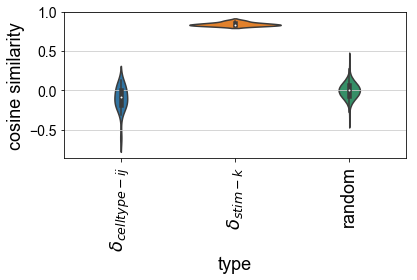

In [27]:
values = np.concatenate([t1.flatten(),h1.flatten(),k.flatten()])
type_val = [r'$\delta_{celltype-ij}$']*len(t1.flatten()) + [r'$\delta_{stim-k}$']*len(h1.flatten()) + \
["random"]*len(k.flatten())
df3 = pd.DataFrame({"cosine similarity"  : values , "type" : type_val})
sns.violinplot(y="cosine similarity", x="type", data=df3)
plt.xticks(rotation=90, fontsize=18)
plt.ylabel("cosine similarity", fontsize=18)
plt.xlabel("type", fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, "SupplFig1c_box_degree_delta_random.pdf"), dpi=300)